In [1]:
#Set up google colab working environment
%cd ~/../content
%rm -rf Colombian-peso-counterfeit-detection
!git clone https://github.com/zrosen3/Colombian-peso-counterfeit-detection.git
%cd /content/Colombian-peso-counterfeit-detection/Code

/content
Cloning into 'Colombian-peso-counterfeit-detection'...
remote: Enumerating objects: 42327, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 42327 (delta 102), reused 50 (delta 33), pack-reused 42174
Receiving objects: 100% (42327/42327), 884.95 MiB | 39.77 MiB/s, done.
Resolving deltas: 100% (1261/1261), done.
Updating files: 100% (103997/103997), done.
/content/Colombian-peso-counterfeit-detection/Code


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import tensorflow as tf
import common_functions as cf

# Load data

In [3]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData(path = "../Data/Augmented/", batch_size=12)


Found 24958 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.


## Create ensemble of CNNs

Create ensemble model

In [4]:
#Initialize keras session
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
#ANN
ann = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(480, 640, 3)),
            tf.keras.layers.Rescaling(1./255),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dense(
                  units = 13,
                activation = "softmax"
          )])
ann.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

ann.fit(
train_ds,
validation_data=validation_ds,
epochs=5)
  
#Model 2 = Custom CNN
cnn = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(len(class_names))])
cnn.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

cnn.fit(
train_ds,
validation_data=validation_ds,
epochs=5)
'''
#Model 3 = CNN-LTSM
cnn_ltsm = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.ConvLSTM2D(16, 3, kernel_regularizer='l2', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(len(class_names)) 
])

cnn_ltsm.compile(
optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])

cnn_ltsm.fit(
train_ds,
validation_data=validation_ds,
epochs=5)

'''

Epoch 1/5
2080/2080 [==============================] - 180s 83ms/step - loss: 71.0299 - accuracy: 0.3688 - val_loss: 14.1554 - val_accuracy: 0.4858
Epoch 2/5
2080/2080 [==============================] - 180s 86ms/step - loss: 23.0720 - accuracy: 0.4829 - val_loss: 21.0247 - val_accuracy: 0.5212
Epoch 3/5
2080/2080 [==============================] - 178s 85ms/step - loss: 12.6660 - accuracy: 0.5421 - val_loss: 5.7776 - val_accuracy: 0.6506
Epoch 4/5
2080/2080 [==============================] - 179s 86ms/step - loss: 12.7129 - accuracy: 0.6241 - val_loss: 1.2170 - val_accuracy: 0.7631
Epoch 5/5
2080/2080 [==============================] - 183s 88ms/step - loss: 4.4555 - accuracy: 0.6799 - val_loss: 31.2951 - val_accuracy: 0.4599
Epoch 1/5
2080/2080 [==============================] - 179s 82ms/step - loss: 2.7236 - accuracy: 0.0765 - val_loss: 2.5649 - val_accuracy: 0.0769
Epoch 2/5
2080/2080 [==============================] - 166s 80ms/step - loss: 2.5650 - accuracy: 0.0769 - val_loss: 2

"\n#Model 3 = CNN-LTSM\ncnn_ltsm = tf.keras.Sequential([\n    tf.keras.layers.Rescaling(1./255),\n    tf.keras.layers.ConvLSTM2D(16, 3, kernel_regularizer='l2', activation='relu'),\n    tf.keras.layers.MaxPooling2D(),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dropout(rate=0.4),\n    tf.keras.layers.Dense(len(class_names)) \n])\n\ncnn_ltsm.compile(\noptimizer='adam',\nloss='sparse_categorical_crossentropy',\nmetrics=['accuracy'])\n\ncnn_ltsm.fit(\ntrain_ds,\nvalidation_data=validation_ds,\nepochs=5)\n\n"

Create ensemble model

In [5]:
models = [ann, cnn]
input_layer = tf.keras.layers.Input(shape=(480, 640, 3))  
outputs = []
for i,model in enumerate(models):
    model._name = str(i)
    output = model(input_layer)
    outputs.append(output)
averaged_outputs = tf.reduce_mean(outputs, axis = 0)
output_layer = tf.keras.layers.Dense(13, activation='softmax')(averaged_outputs)  
ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

Fit ensemble model



In [6]:
ensemble_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

history = ensemble_model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=5)

Epoch 1/5
2080/2080 [==============================] - 246s 116ms/step - loss: 1.1019 - accuracy: 0.7351 - val_loss: 0.1980 - val_accuracy: 0.9410
Epoch 2/5
2080/2080 [==============================] - 247s 119ms/step - loss: 0.1049 - accuracy: 0.9674 - val_loss: 0.1262 - val_accuracy: 0.9629
Epoch 3/5
2080/2080 [==============================] - 248s 119ms/step - loss: 0.0645 - accuracy: 0.9805 - val_loss: 0.1786 - val_accuracy: 0.9486
Epoch 4/5
2080/2080 [==============================] - 236s 114ms/step - loss: 0.0527 - accuracy: 0.9839 - val_loss: 0.1852 - val_accuracy: 0.9547
Epoch 5/5
2080/2080 [==============================] - 254s 122ms/step - loss: 0.0480 - accuracy: 0.9841 - val_loss: 0.1592 - val_accuracy: 0.9651


## Inspect model performance

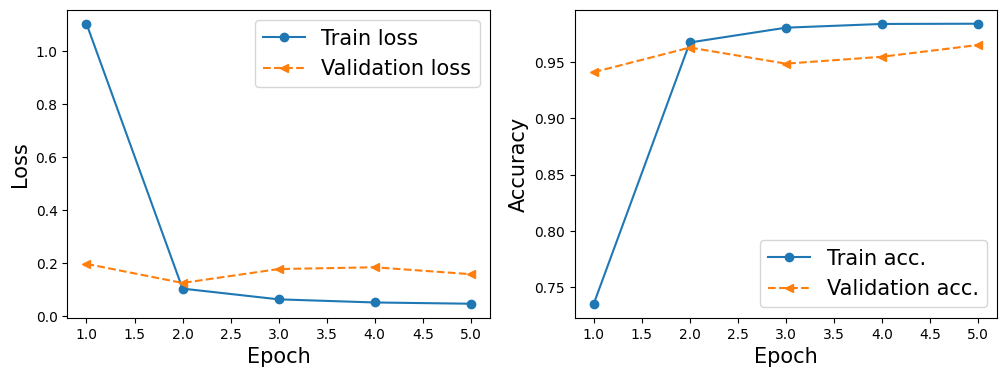

694/694 - 43s - loss: 0.1755 - accuracy: 0.9633 - 43s/epoch - 62ms/step
Test loss: 0.17548489570617676 | Test accuracy: 0.9633413553237915


(0.9840531945228577, 0.9651442170143127, 0.9633413553237915)

In [7]:
cf.EvaluateModel(ensemble_model, test_ds, history)
